In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import evaluate
import gensim
import transformers
import nltk
import torch_geometric
import json
from xml.dom import minidom
from tqdm import tqdm

from modeling import testModel

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

c:\Users\wangz\anaconda3\envs\sp\lib\site-packages\torch\onnx\_internal\_beartype.py:35: UserWarning: module 'beartype.roar' has no attribute 'BeartypeDecorHintPep585DeprecationWarning'
  warnings.warn(f"{e}")


In [2]:
# This cell makes sure modules are auto-loaded when you change external python files
%load_ext autoreload
%autoreload 2

In [3]:
def read_svg_string(svg_strings):
    edge_list = []
    edge_index = []
    ps = 0
    pe = 0

    panel_list = []

    for i in svg_strings:
        ps = pe
        tmp = i.split()
        prev_x = float(tmp[1])
        prev_y = float(tmp[2])
        j = 3
        while j < len(tmp):
            edge = [prev_x, prev_y]
            if tmp[j] == 'z':
                break

            if tmp[j] == 'L':
                edge.append(float(tmp[j+1]))
                edge.append(float(tmp[j+2]))
                prev_x = float(tmp[j+1])
                prev_y = float(tmp[j+2])
                edge.append((edge[0] + edge[2]) / 2)
                edge.append((edge[1] + edge[3]) / 2)
                j = j + 3
                pe += 1
                edge_list.append(edge)
                continue
            if tmp[j] == 'Q':
                prev_x = float(tmp[j+3])
                prev_y = float(tmp[j+4])
                edge.append(float(tmp[j+3]))
                edge.append(float(tmp[j+4]))
                edge.append(float(tmp[j+1]))
                edge.append(float(tmp[j+2]))
                j = j + 5
                pe += 1
                edge_list.append(edge)
                continue
        for j in range(ps, pe - 1):
            edge_index.append([j, j + 1])
        edge_index.append([pe - 1, ps])
        panel_list.append(pe - ps)

    edge_list = [convert_to_4(i) for i in edge_list]
    return [edge_list,edge_index, panel_list]
            


In [4]:
def convert_to_4(data):
    start_p = np.array([data[0], data[1]])
    end_p = np.array([data[2], data[3]])
    center_p = np.array([data[4], data[5]])

    line = end_p - start_p
    p_line = np.empty_like(line)
    p_line[0] = - line[1]
    p_line[1] = line[0]

    v = center_p - start_p
    cx = np.dot(line, v) / np.linalg.norm(line)
    cy = np.dot(p_line, v) / np.linalg.norm(p_line)

    return [line[0], line[1], cx, cy]

In [5]:
def get_data_from_spec(file_path):
    doc = minidom.parse(file_path)  # parseString also exists
    path_strings = [path.getAttribute('d') for path
                in doc.getElementsByTagName('path')]
    res = read_svg_string(path_strings)
    return res

In [6]:
def backto6(file_name, out, panel_list):
    doc = minidom.parse(file_name)  # parseString also exists
    path_strings = [path.getAttribute('d') for path
                in doc.getElementsByTagName('path')]
    index = 0

    res = []
    
    for i, path in enumerate(path_strings):
        path = path.split()
        prev_x = float(path[1])
        prev_y = float(path[2])

        count = 1
        while count <= panel_list[i]:
            count += 1
            cur_x = prev_x + out[index][0]
            cur_y = prev_y + out[index][1]
            start_p = np.array([prev_x, prev_y])
            end_p = np.array([cur_x, cur_y])

            line = end_p - start_p
            
            p_line = np.empty_like(line)
            p_line[0] = - line[1]
            p_line[1] = line[0]

            center_p = start_p + line * out[index][2] / np.linalg.norm(line) + p_line * out[index][3] / np.linalg.norm(p_line)
            index += 1
            res.append([prev_x,prev_y, cur_x, cur_y, center_p[0], center_p[1]])
            prev_x = cur_x
            prev_y = cur_y
    return res

In [7]:
from os import listdir
from os.path import isfile, join
import random

mypath = "pants_straight_sides_1000"

onlyfiles_pants = [join(mypath,f, f + "_pattern.svg") for f in listdir(mypath) if not isfile(join(mypath, f))]
random.shuffle(onlyfiles_pants)

file_names_pants = [f for f in listdir(mypath) if not isfile(join(mypath, f))]

mypath = "skirt_2_panels_1200"

onlyfiles_skirt = [join(mypath,f, f + "_pattern.svg") for f in listdir(mypath) if not isfile(join(mypath, f))]
random.shuffle(onlyfiles_skirt)

file_names_skirt = [f for f in listdir(mypath) if not isfile(join(mypath, f))]

In [8]:
data_pants = [get_data_from_spec(i) for i in onlyfiles_pants]
data_skirt = [get_data_from_spec(i) for i in onlyfiles_skirt]

train_data_pants = data_pants[100:]
test_data_pants = data_pants[:100]

train_data_skirt = data_skirt[100:]
test_data_skirt = data_skirt[:100]

train_data = train_data_pants + train_data_skirt
test_data = test_data_pants + test_data_skirt

In [ ]:
# -321 -- +408

In [10]:
lr = 1e-3
num_epochs = 200
n_classes= 147

model = testModel(4, 4 * n_classes, device).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [100, 150], gamma=0.1)

In [11]:
#training



train_loss_list = []
eval_loss_list = []

helper = [i for i in range(-321, 409)]
helper = torch.tensor(helper).to(device)

for epoch in tqdm(range(num_epochs), leave=False, position=0):
    
    epoch_loss = 0
    model.train()
    for data in tqdm(train_data, leave=False, position=1):
        

        label = []
        for i in data[0]:
            for j in i:
                #label.append(round(j + 321))
                label.append(round((j + 321) / 5))
        label = torch.tensor(label).to(torch.long).to(device)
        
        input_data = torch.tensor(data[0]).to(torch.float).to(device)
        edge_index = torch.tensor(data[1]).to(device).permute(1,0)
            
        # Forward pass
        out = model(input_data, edge_index)
        #print(decoder_outputs.size())
            
        # print(out.shape)
        out = out.reshape(-1, n_classes)
        # Compute loss
        loss = criterion(out, label)
        """ # the loss of enclosing
        tmp = out.reshape(-1, 4, 730)
        tmp = tmp * helper
        tmp = tmp.sum(-1)
        tmp = tmp.sum(dim = 0)
        
        
        loss_0 = torch.square(tmp[0]) + torch.square(tmp[1])
        loss += loss_0 """

        
        epoch_loss += loss.item()
            
            
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()
        
    
        

    print(f'Epoch {epoch + 1} | Train Loss: {(epoch_loss / len(train_data)):.4f}')
    train_loss_list.append(epoch_loss / len(train_data))
    #eval
    eval_loss = 0
    model.eval()
    with torch.no_grad():
        for data in  test_data:

            label = []
            for i in data[0]:
                for j in i:
                    #label.append(round(j + 321))
                    label.append(round((j + 321) / 5))
            label = torch.tensor(label).to(torch.long).to(device)

            input_data = torch.tensor(data[0]).to(torch.float).to(device)
            edge_index = torch.tensor(data[1]).to(device).permute(1,0)
                
            # Forward pass
            out = model(input_data, edge_index)
            #print(decoder_outputs.size())
            out = out.reshape(-1, n_classes)
            # Compute loss
            loss = criterion(out, label)
            """  # the loss of enclosing
            tmp = out.reshape(-1, 4, 730)
            tmp = tmp * helper
            tmp = tmp.sum(-1)
            tmp = tmp.sum(dim = 0)
            
            
            loss_0 = torch.square(tmp[0]) + torch.square(tmp[1])
            loss += loss_0 """
            
            eval_loss += loss.item()
    print(f'Epoch {epoch + 1} | Eval Loss: {(eval_loss / len(test_data)):.4f}')
    eval_loss_list.append(eval_loss / len(test_data))
        
        

  0%|          | 0/200 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 1.9709


  0%|          | 1/200 [00:46<2:35:26, 46.87s/it]

Epoch 1 | Eval Loss: 2.0405


Epoch 2 | Train Loss: 1.4906


  1%|          | 2/200 [01:32<2:32:57, 46.35s/it]

Epoch 2 | Eval Loss: 1.6298


Epoch 3 | Train Loss: 1.3604


  2%|▏         | 3/200 [02:18<2:31:18, 46.09s/it]

Epoch 3 | Eval Loss: 1.4788


Epoch 4 | Train Loss: 1.2980


  2%|▏         | 4/200 [03:04<2:30:23, 46.04s/it]

Epoch 4 | Eval Loss: 1.3935


Epoch 5 | Train Loss: 1.2575


  2%|▎         | 5/200 [03:50<2:29:25, 45.98s/it]

Epoch 5 | Eval Loss: 1.3363


Epoch 6 | Train Loss: 1.2273


  3%|▎         | 6/200 [04:38<2:30:24, 46.52s/it]

Epoch 6 | Eval Loss: 1.2950


Epoch 7 | Train Loss: 1.2030


  4%|▎         | 7/200 [05:24<2:29:24, 46.45s/it]

Epoch 7 | Eval Loss: 1.2633


Epoch 8 | Train Loss: 1.1825


  4%|▍         | 8/200 [07:00<3:19:17, 62.28s/it]

Epoch 8 | Eval Loss: 1.2377


Epoch 9 | Train Loss: 1.1646


  4%|▍         | 9/200 [08:48<4:03:30, 76.50s/it]

Epoch 9 | Eval Loss: 1.2164


Epoch 10 | Train Loss: 1.1488


  5%|▌         | 10/200 [10:36<4:33:19, 86.32s/it]

Epoch 10 | Eval Loss: 1.1980


Epoch 11 | Train Loss: 1.1344


  6%|▌         | 11/200 [12:23<4:52:11, 92.76s/it]

Epoch 11 | Eval Loss: 1.1819


Epoch 12 | Train Loss: 1.1213


  6%|▌         | 12/200 [13:38<4:33:44, 87.36s/it]

Epoch 12 | Eval Loss: 1.1675


Epoch 13 | Train Loss: 1.1092


  6%|▋         | 13/200 [14:25<3:53:43, 74.99s/it]

Epoch 13 | Eval Loss: 1.1545


Epoch 14 | Train Loss: 1.0980


  7%|▋         | 14/200 [15:14<3:27:48, 67.03s/it]

Epoch 14 | Eval Loss: 1.1425


Epoch 15 | Train Loss: 1.0875


  8%|▊         | 15/200 [16:01<3:08:15, 61.06s/it]

Epoch 15 | Eval Loss: 1.1315


Epoch 16 | Train Loss: 1.0777


  8%|▊         | 16/200 [16:47<2:53:17, 56.51s/it]

Epoch 16 | Eval Loss: 1.1212


Epoch 17 | Train Loss: 1.0684


  8%|▊         | 17/200 [17:50<2:58:23, 58.49s/it]

Epoch 17 | Eval Loss: 1.1115


Epoch 18 | Train Loss: 1.0596


  9%|▉         | 18/200 [18:54<3:02:36, 60.20s/it]

Epoch 18 | Eval Loss: 1.1024


Epoch 19 | Train Loss: 1.0513


 10%|▉         | 19/200 [19:41<2:49:48, 56.29s/it]

Epoch 19 | Eval Loss: 1.0938


Epoch 20 | Train Loss: 1.0434


 10%|█         | 20/200 [20:27<2:39:20, 53.11s/it]

Epoch 20 | Eval Loss: 1.0857


Epoch 21 | Train Loss: 1.0358


 10%|█         | 21/200 [21:13<2:32:10, 51.01s/it]

Epoch 21 | Eval Loss: 1.0779


Epoch 22 | Train Loss: 1.0286


 11%|█         | 22/200 [21:59<2:26:36, 49.42s/it]

Epoch 22 | Eval Loss: 1.0704


Epoch 23 | Train Loss: 1.0217


 12%|█▏        | 23/200 [22:44<2:22:30, 48.31s/it]

Epoch 23 | Eval Loss: 1.0632


Epoch 24 | Train Loss: 1.0151


 12%|█▏        | 24/200 [23:30<2:19:27, 47.54s/it]

Epoch 24 | Eval Loss: 1.0564


Epoch 25 | Train Loss: 1.0087


 12%|█▎        | 25/200 [24:17<2:17:49, 47.25s/it]

Epoch 25 | Eval Loss: 1.0498


Epoch 26 | Train Loss: 1.0026


 13%|█▎        | 26/200 [25:05<2:17:38, 47.46s/it]

Epoch 26 | Eval Loss: 1.0434


Epoch 27 | Train Loss: 0.9967


 14%|█▎        | 27/200 [25:50<2:15:12, 46.90s/it]

Epoch 27 | Eval Loss: 1.0373


Epoch 28 | Train Loss: 0.9911


 14%|█▍        | 28/200 [26:37<2:14:19, 46.86s/it]

Epoch 28 | Eval Loss: 1.0314


Epoch 29 | Train Loss: 0.9856


 14%|█▍        | 29/200 [27:23<2:12:52, 46.62s/it]

Epoch 29 | Eval Loss: 1.0257


Epoch 30 | Train Loss: 0.9803


 15%|█▌        | 30/200 [28:08<2:10:22, 46.02s/it]

Epoch 30 | Eval Loss: 1.0202


Epoch 31 | Train Loss: 0.9752


 16%|█▌        | 31/200 [29:05<2:19:15, 49.44s/it]

Epoch 31 | Eval Loss: 1.0148


Epoch 32 | Train Loss: 0.9702


 16%|█▌        | 32/200 [30:00<2:23:06, 51.11s/it]

Epoch 32 | Eval Loss: 1.0096


Epoch 33 | Train Loss: 0.9654


 16%|█▋        | 33/200 [30:50<2:21:30, 50.84s/it]

Epoch 33 | Eval Loss: 1.0046


Epoch 34 | Train Loss: 0.9607


 17%|█▋        | 34/200 [31:36<2:16:01, 49.16s/it]

Epoch 34 | Eval Loss: 0.9998


Epoch 35 | Train Loss: 0.9562


 18%|█▊        | 35/200 [32:22<2:12:30, 48.19s/it]

Epoch 35 | Eval Loss: 0.9950


Epoch 36 | Train Loss: 0.9518


 18%|█▊        | 36/200 [33:08<2:09:54, 47.53s/it]

Epoch 36 | Eval Loss: 0.9905


Epoch 37 | Train Loss: 0.9475


 18%|█▊        | 37/200 [33:55<2:09:16, 47.59s/it]

Epoch 37 | Eval Loss: 0.9860


Epoch 38 | Train Loss: 0.9433


 19%|█▉        | 38/200 [34:45<2:10:21, 48.28s/it]

Epoch 38 | Eval Loss: 0.9817


Epoch 39 | Train Loss: 0.9392


 20%|█▉        | 39/200 [35:32<2:08:40, 47.95s/it]

Epoch 39 | Eval Loss: 0.9775


Epoch 40 | Train Loss: 0.9353


 20%|██        | 40/200 [36:19<2:07:09, 47.68s/it]

Epoch 40 | Eval Loss: 0.9734


Epoch 41 | Train Loss: 0.9314


 20%|██        | 41/200 [37:06<2:05:44, 47.45s/it]

Epoch 41 | Eval Loss: 0.9695


Epoch 42 | Train Loss: 0.9276


 21%|██        | 42/200 [37:53<2:04:38, 47.33s/it]

Epoch 42 | Eval Loss: 0.9656


Epoch 43 | Train Loss: 0.9240


 22%|██▏       | 43/200 [38:41<2:03:52, 47.34s/it]

Epoch 43 | Eval Loss: 0.9618


Epoch 44 | Train Loss: 0.9204


 22%|██▏       | 44/200 [39:30<2:04:39, 47.94s/it]

Epoch 44 | Eval Loss: 0.9582


Epoch 45 | Train Loss: 0.9168


 22%|██▎       | 45/200 [40:20<2:05:12, 48.47s/it]

Epoch 45 | Eval Loss: 0.9546


Epoch 46 | Train Loss: 0.9134


 23%|██▎       | 46/200 [41:08<2:04:12, 48.39s/it]

Epoch 46 | Eval Loss: 0.9511


Epoch 47 | Train Loss: 0.9101


 24%|██▎       | 47/200 [41:57<2:03:53, 48.59s/it]

Epoch 47 | Eval Loss: 0.9477


Epoch 48 | Train Loss: 0.9068


 24%|██▍       | 48/200 [42:47<2:03:48, 48.87s/it]

Epoch 48 | Eval Loss: 0.9444


Epoch 49 | Train Loss: 0.9036


 24%|██▍       | 49/200 [43:37<2:03:46, 49.18s/it]

Epoch 49 | Eval Loss: 0.9412


Epoch 50 | Train Loss: 0.9004


 25%|██▌       | 50/200 [44:25<2:02:21, 48.94s/it]

Epoch 50 | Eval Loss: 0.9380


Epoch 51 | Train Loss: 0.8973


 26%|██▌       | 51/200 [45:15<2:02:19, 49.26s/it]

Epoch 51 | Eval Loss: 0.9350


Epoch 52 | Train Loss: 0.8943


 26%|██▌       | 52/200 [46:05<2:02:15, 49.56s/it]

Epoch 52 | Eval Loss: 0.9319


Epoch 53 | Train Loss: 0.8913


 26%|██▋       | 53/200 [46:53<2:00:28, 49.17s/it]

Epoch 53 | Eval Loss: 0.9290


Epoch 54 | Train Loss: 0.8884


 27%|██▋       | 54/200 [47:41<1:58:49, 48.83s/it]

Epoch 54 | Eval Loss: 0.9261


Epoch 55 | Train Loss: 0.8856


 28%|██▊       | 55/200 [48:29<1:57:19, 48.55s/it]

Epoch 55 | Eval Loss: 0.9232


Epoch 56 | Train Loss: 0.8828


 28%|██▊       | 56/200 [49:17<1:56:00, 48.33s/it]

Epoch 56 | Eval Loss: 0.9204


Epoch 57 | Train Loss: 0.8801


 28%|██▊       | 57/200 [50:08<1:57:19, 49.23s/it]

Epoch 57 | Eval Loss: 0.9177


Epoch 58 | Train Loss: 0.8774


 29%|██▉       | 58/200 [50:57<1:55:56, 48.99s/it]

Epoch 58 | Eval Loss: 0.9150


Epoch 59 | Train Loss: 0.8747


 30%|██▉       | 59/200 [51:46<1:54:49, 48.86s/it]

Epoch 59 | Eval Loss: 0.9124


Epoch 60 | Train Loss: 0.8721


 30%|███       | 60/200 [52:34<1:53:28, 48.63s/it]

Epoch 60 | Eval Loss: 0.9098


Epoch 61 | Train Loss: 0.8696


 30%|███       | 61/200 [53:22<1:52:18, 48.48s/it]

Epoch 61 | Eval Loss: 0.9073


Epoch 62 | Train Loss: 0.8671


 31%|███       | 62/200 [54:10<1:51:14, 48.37s/it]

Epoch 62 | Eval Loss: 0.9048


Epoch 63 | Train Loss: 0.8646


 32%|███▏      | 63/200 [55:00<1:51:54, 49.01s/it]

Epoch 63 | Eval Loss: 0.9024


Epoch 64 | Train Loss: 0.8622


 32%|███▏      | 64/200 [55:48<1:50:25, 48.71s/it]

Epoch 64 | Eval Loss: 0.9000


Epoch 65 | Train Loss: 0.8598


 32%|███▎      | 65/200 [56:35<1:48:22, 48.16s/it]

Epoch 65 | Eval Loss: 0.8977


Epoch 66 | Train Loss: 0.8575


 33%|███▎      | 66/200 [57:26<1:49:11, 48.89s/it]

Epoch 66 | Eval Loss: 0.8954


Epoch 67 | Train Loss: 0.8551


 34%|███▎      | 67/200 [59:37<2:43:02, 73.56s/it]

Epoch 67 | Eval Loss: 0.8932


Epoch 68 | Train Loss: 0.8529


 34%|███▍      | 68/200 [1:01:47<3:19:17, 90.59s/it]

Epoch 68 | Eval Loss: 0.8910


Epoch 69 | Train Loss: 0.8506


 34%|███▍      | 69/200 [1:03:59<3:44:30, 102.83s/it]

Epoch 69 | Eval Loss: 0.8888


Epoch 70 | Train Loss: 0.8484


 35%|███▌      | 70/200 [1:06:10<4:01:27, 111.44s/it]

Epoch 70 | Eval Loss: 0.8866


Epoch 71 | Train Loss: 0.8463


 36%|███▌      | 71/200 [1:08:18<4:10:06, 116.33s/it]

Epoch 71 | Eval Loss: 0.8845


Epoch 72 | Train Loss: 0.8441


 36%|███▌      | 72/200 [1:10:29<4:17:48, 120.85s/it]

Epoch 72 | Eval Loss: 0.8825


Epoch 73 | Train Loss: 0.8420


 36%|███▋      | 73/200 [1:12:17<4:07:26, 116.90s/it]

Epoch 73 | Eval Loss: 0.8804


Epoch 74 | Train Loss: 0.8399


 37%|███▋      | 74/200 [1:14:42<4:23:02, 125.25s/it]

Epoch 74 | Eval Loss: 0.8784


Epoch 75 | Train Loss: 0.8379


 38%|███▊      | 75/200 [1:18:40<5:31:29, 159.11s/it]

Epoch 75 | Eval Loss: 0.8764


Epoch 76 | Train Loss: 0.8359


 38%|███▊      | 76/200 [1:22:31<6:13:24, 180.68s/it]

Epoch 76 | Eval Loss: 0.8745


Epoch 77 | Train Loss: 0.8339


 38%|███▊      | 77/200 [1:24:11<5:21:08, 156.65s/it]

Epoch 77 | Eval Loss: 0.8726


Epoch 78 | Train Loss: 0.8319


 39%|███▉      | 78/200 [1:26:18<5:00:14, 147.66s/it]

Epoch 78 | Eval Loss: 0.8707


Epoch 79 | Train Loss: 0.8300


 40%|███▉      | 79/200 [1:28:23<4:44:16, 140.96s/it]

Epoch 79 | Eval Loss: 0.8688


Epoch 80 | Train Loss: 0.8281


 40%|████      | 80/200 [1:30:30<4:33:23, 136.69s/it]

Epoch 80 | Eval Loss: 0.8670


Epoch 81 | Train Loss: 0.8262


 40%|████      | 81/200 [1:32:35<4:24:15, 133.24s/it]

Epoch 81 | Eval Loss: 0.8652


Epoch 82 | Train Loss: 0.8243


 41%|████      | 82/200 [1:34:43<4:18:28, 131.43s/it]

Epoch 82 | Eval Loss: 0.8634


Epoch 83 | Train Loss: 0.8225


 42%|████▏     | 83/200 [1:36:25<3:59:29, 122.82s/it]

Epoch 83 | Eval Loss: 0.8617


Epoch 84 | Train Loss: 0.8207


 42%|████▏     | 84/200 [1:38:30<3:58:41, 123.46s/it]

Epoch 84 | Eval Loss: 0.8599


Epoch 85 | Train Loss: 0.8189


 42%|████▎     | 85/200 [1:40:40<4:00:29, 125.47s/it]

Epoch 85 | Eval Loss: 0.8582


Epoch 86 | Train Loss: 0.8171


 43%|████▎     | 86/200 [1:42:49<3:59:55, 126.27s/it]

Epoch 86 | Eval Loss: 0.8565


Epoch 87 | Train Loss: 0.8154


 44%|████▎     | 87/200 [1:44:59<4:00:08, 127.51s/it]

Epoch 87 | Eval Loss: 0.8549


Epoch 88 | Train Loss: 0.8136


 44%|████▍     | 88/200 [1:47:06<3:57:59, 127.50s/it]

Epoch 88 | Eval Loss: 0.8532


Epoch 89 | Train Loss: 0.8119


 44%|████▍     | 89/200 [1:48:55<3:45:27, 121.87s/it]

Epoch 89 | Eval Loss: 0.8516


Epoch 90 | Train Loss: 0.8103


 45%|████▌     | 90/200 [1:50:36<3:31:52, 115.57s/it]

Epoch 90 | Eval Loss: 0.8500


Epoch 91 | Train Loss: 0.8086


 46%|████▌     | 91/200 [1:52:44<3:36:55, 119.41s/it]

Epoch 91 | Eval Loss: 0.8484


Epoch 92 | Train Loss: 0.8070


 46%|████▌     | 92/200 [1:54:56<3:41:15, 122.92s/it]

Epoch 92 | Eval Loss: 0.8469


Epoch 93 | Train Loss: 0.8053


 46%|████▋     | 93/200 [1:57:02<3:40:51, 123.85s/it]

Epoch 93 | Eval Loss: 0.8454


Epoch 94 | Train Loss: 0.8037


 47%|████▋     | 94/200 [1:59:10<3:41:17, 125.26s/it]

Epoch 94 | Eval Loss: 0.8438


Epoch 95 | Train Loss: 0.8021


 48%|████▊     | 95/200 [2:01:20<3:41:37, 126.64s/it]

Epoch 95 | Eval Loss: 0.8423


Epoch 96 | Train Loss: 0.8006


 48%|████▊     | 96/200 [2:03:28<3:40:01, 126.94s/it]

Epoch 96 | Eval Loss: 0.8409


Epoch 97 | Train Loss: 0.7990


 48%|████▊     | 97/200 [2:04:25<3:01:51, 105.94s/it]

Epoch 97 | Eval Loss: 0.8394


KeyboardInterrupt: 

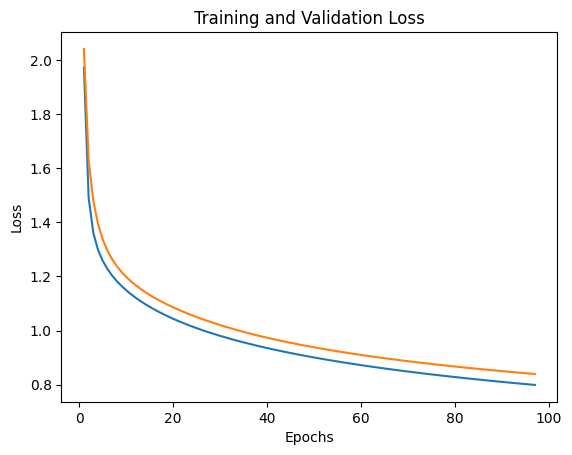

In [13]:
from matplotlib.pylab import plt

epochs = range(1, 98)

plt.plot(epochs, train_loss_list, label='Training Loss')
plt.plot(epochs, eval_loss_list, label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [14]:
torch.save(model.state_dict(), 'models/classification(90)_4layers.pt')

In [16]:
def save_res(file_name, out):
    doc = minidom.parse(file_name)
    for i in out:
        tmp = []
        tmp.append('M')
        
        tmp.append(str(i[0]))
        tmp.append(str(i[1]))
        tmp.append("Q")
        tmp.append(str(i[4]))
        tmp.append(str(i[5]))
        tmp.append(str(i[2]))
        tmp.append(str(i[3]))
        x = doc.createElement("path")
        x.setAttribute("d" , " ".join(tmp))
        x.setAttribute("stroke" , "red")
        x.setAttribute("fill" , "none")
        doc.childNodes[0].appendChild(x)
    
    doc.writexml(open(join("res1", file_name[-37:-4] + "_res.svg"), 'w'))
    

In [11]:
model = testModel(4, 4 * n_classes).to(device)
model.load_state_dict(torch.load('models/classification(50_50)_4layers.pt'))
model.eval()

testModel(
  (sage1): SAGEConv(4, 16, aggr=mean)
  (relu): ReLU()
  (sage2): SAGEConv(16, 32, aggr=mean)
  (sage3): SAGEConv(32, 64, aggr=mean)
  (sage4): SAGEConv(64, 128, aggr=mean)
  (resnet): ResNet1D(
    (first_block_conv): MyConv1dPadSame(
      (conv): Conv1d(128, 64, kernel_size=(2,), stride=(1,))
    )
    (first_block_bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (first_block_relu): ReLU()
    (basicblock_list): ModuleList(
      (0-3): 4 x BasicBlock(
        (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU()
        (do1): Dropout(p=0.5, inplace=False)
        (conv1): MyConv1dPadSame(
          (conv): Conv1d(64, 64, kernel_size=(2,), stride=(1,))
        )
        (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU()
        (do2): Dropout(p=0.5, inplace=False)
        (conv2): MyConv1dPadSame(
          (conv): C

In [17]:
#names = onlyfiles_pants[:100] + onlyfiles_skirt[:100]
names = onlyfiles_pants[-100:] + onlyfiles_skirt[-100:]

for name in names:
    a = get_data_from_spec(name)
    data = torch.tensor(a[0]).to(torch.float).to(device)
    edge_index = torch.tensor(a[1]).to(device).permute(1,0)
    
    
    out = model(data, edge_index)
    out = out.reshape(-1, n_classes)
    out = torch.argmax(out, dim=-1) * 5 - 320
    out =  out.reshape(-1,4)
    print(out.sum(0))
    out = out.tolist()
    

    out = backto6(name, out, a[2])

    save_res(name,out)

tensor([   0,   10,  915, -100], device='cuda:0')
tensor([  0,  25, 985, -85], device='cuda:0')
tensor([ -45,   -5, 1475,  -80], device='cuda:0')
tensor([  0,  20, 895, -90], device='cuda:0')
tensor([  5,  15, 975, -85], device='cuda:0')
tensor([  -5,   35, 1260,  -85], device='cuda:0')
tensor([   5,   10, 1050,  -90], device='cuda:0')
tensor([  20,  -75, 1130,  -90], device='cuda:0')
tensor([  10,   -5, 1220,  -90], device='cuda:0')
tensor([  0, -20, 940, -85], device='cuda:0')
tensor([  -5,  -10,  885, -100], device='cuda:0')
tensor([  20,   20, 1265,  -70], device='cuda:0')
tensor([  15,  -40, 1395,  -80], device='cuda:0')
tensor([ -10,   40, 1255,  -95], device='cuda:0')
tensor([  10,  -20, 1015,  -80], device='cuda:0')
tensor([  5,  10, 830, -95], device='cuda:0')
tensor([-25,  15, 835, -95], device='cuda:0')
tensor([ 15,  25, 930, -85], device='cuda:0')
tensor([ 10,  -5, 980, -85], device='cuda:0')
tensor([  -5,   50, 1270, -100], device='cuda:0')
tensor([  10,   20, 1140,  -75],